In [1]:
import numpy as np
import scipy.stats as sc
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from time import sleep
import pandas as pd
import math
import random
from IPython import display
import time
import matplotlib.pyplot as plt

In [35]:
### Global variables ###

# "Bucket-A" arrays
c1 = [] # class 1
c2 = [] # class 2
c3 = [] # class 3
c4 = [] # class 4
I_s = [] # infected symptomatic
R = [] # all recovered or vaccinated agents

# "Bucket-B" arrays
S = [] # all susceptable agents
I = [] # all infected agents
V = [] # all vaccinated agents

c_every = [c1, c2, c3, c4, I_s]

class_populations = [1000, 1000, 1000, 1000, 0]       # initial populations of classes C1, C2, C3, C4, and I_s
n_population = sum(class_populations)      # total population
class_init_infected = [5, 5, 5, 5]       # number of agents initially infected in classes C1, C2, C3, C4
class_p = [0.8, 0.8, 0.8, 0.8]       # probability that an infected agent is symptomatic in classes C1, C2, C3, C4


# array of meeting rates (infection transmissions per day) of classes C1, C2, C3, C4, and infected symptomatic (I_s) agents
meeting_rates = [0.2, 0.3, 0.2, 0.05, 0.0714]
            
# create array of meeting rates [i,j] of agent with meeting rate i meeting an agent with meeting rate j
# this is a symmetric array because this relationship between i,j is symmetric
meeting_rate_matrix = np.zeros((5,5))
for i in range(5):
    for j in range(5):
        meeting_rate_matrix[i,j] = max(meeting_rates[i], meeting_rates[j])


# create array [i,j] of the proportion of agents that class i meets who are from from class j during any given time period
# So all rows will sum to 1, but this is not a symmetric matrix because i,j relationship is not symmetric here
# Classes:
# 1 - medical workers
# 2 - essential non med
# 3 - non essential high risk
# 4 - non essential low risk
# 5 - infected and symptomatic
proportion_matrix = (([0.15, 0.15, 0.15, 0.15, 0.40], # medical workers meet highest percentage of infected symptomatic
                      [0.10, 0.20, 0.35, 0.35, 0.00], # essential non-med see high percentage of non essential workers
                      [0.10, 0.15, 0.38, 0.37, 0.00], # non essential workers see high percentage of other non essential workers
                      [0.10, 0.15, 0.38, 0.37, 0.00], # non essential workers see high percentage of other non essential workers
                      [1.00, 0.00, 0.00, 0.00, 0.00])) # symptomatic infected only see medical workers


recover_rate = 0.0714

### Classes ###

class Agent:
    # Create class for an agents object
    def __init__(self, class_n, meeting_rate, infected, p, name):
        self.class_n = class_n
        self.previous_class = None 
        self.meeting_rate = meeting_rate
        self.infected = infected
        self.p = p
        self.name = str(name)
    
    def infect(self):
        # Update agent's infected status and remove them from list S
        # Decide if they become symptomatic
        # If symptomatic, adjust meeting rate and move to list I_s
        self.infected = True
        self.previous_class = self.class_n
        S.remove(self)
        I.append(self)
        U = np.random.rand()
        if (U < self.p):
            self.meeting_rate = meeting_rates[4]
            if (self.class_n == 1):
                c1.remove(self)
            elif (self.class_n == 2):
                c2.remove(self)
            elif (self.class_n == 3):
                c3.remove(self)
            else:
                c4.remove(self)
            I_s.append(self)
            self.class_n = 5
            
    def vaccinate(self):
        # Move agent to appropriate arrays for a vaccinated agent
        S.remove(self)
        if (self.class_n == 1):
            c1.remove(self)
        elif (self.class_n == 2):
            c2.remove(self)
        elif (self.class_n == 3):
            c3.remove(self)
        else:
            c4.remove(self)
        R.append(self)
        V.append(self)


    def recover(self):
        # Update agent's infection status to healthy and move to appropriate arrays
        I.remove(self)
        if (self.class_n == 1):
            c1.remove(self)
        elif (self.class_n == 2):
            c2.remove(self)
        elif (self.class_n == 3):
            c3.remove(self)
        elif (self.class_n == 4):
            c4.remove(self)
        else:
            I_s.remove(self)
        R.append(self)
        
    def disp(self):
        # function to return name of agent's work type
        ret = ''
        if (self.previous_class == 1):
            ret = 'medical worker'
        elif (self.previous_class == 2):
            ret = 'essential non-medical worker'
        elif (self.previous_class == 3):
            ret = 'non-essential high-risk'
        else:
            ret = 'non-essential low-risk'
        return ret + ' #' + self.name

### Helper functions ###

def simOccDiff(class1, class2):
    found_inf = False
    i = 0
    while(not found_inf and i < len(I)):
        if (I[i].class_n == class1 or I[i].class_n == class2):
            found_inf = True
            break
        else:
            i += 1

    found_healthy = False
    if (found_inf):
        other = c_every[class1 - 1]
        if (I[i].class_n == class1):
            other = c_every[class2 - 1]
        j = 0
        while(not found_healthy and j < len(other)):
            if (other[j].infected == False):
                found_healthy = True
                break
            else:
                j += 1
    if (found_healthy):
        other[j].infect()
        
def simOccSame(classNum):
    class_arr = c_every[classNum - 1]
    found_inf = False
    i = 0
    while(not found_inf and i < len(class_arr)):
        if (class_arr[i].infected == True):
            found_inf = True
            break
        else:
            i += 1
    found_healthy = False
    if (found_inf):
        i = 0
        while(not found_healthy and i < len(class_arr)):
            if (class_arr[i].infected == False):
                found_healthy = True
                break
            else:
                i += 1
    if (found_healthy):
        class_arr[i].infect()

def display_arr(arr):
    # function to return the work types of agents in input array
    ret = ''
    for i in arr:
        ret += i.disp() + ', '
    return '[' + ret[:-2] + ']'


def show_infected(class_type, infected_array, resistant_array, total_population):
    """
    Graphs bar plot of the total number of infected, for one class.  
    
    input: 
    class_type -> given class want to visualize
    infected_array_symp -> total people symptomatic 
    resistant_array_asymp -> total people asymptomaptic 
    total_population of given class
    
    output: 
    visualization of the percent of class_type infected at time t 
    """
    
    count_sick = 0
    for sick_person in (infected_array):
        if sick_person.previous_class == class_type: 
            count_sick += 1 
    
    percent_sick_total = (count_sick)/total_population 
    return plt.barh(["C" + str(class_type)], percent_sick_total)


def show_population_resistance(R, class_populations):
    """
    Graphs bar plot of the total number of resistant
    
    input: 
    resistant_array -> total people resistant 
    total_population of given class
    
    output: 
    visualization of the percent of resistance (immunity) of total population at time t 
    """

    total_population = np.sum(class_populations) 
    percent_immune_total = (len(R))/total_population 
    return plt.barh(["Resistant"], percent_immune_total)


def bar_graph(n_frame):
    # Bar Graph Animated Visual function
    x_ax = ['Susceptible', 'Infected', 'Symptomatic Infected', 'Resistant']
    colors = ['gold', 'lightcoral', 'firebrick', 'royalblue']
    n_out = []

    for n in range(0, len(n_frame), 200):
        display.clear_output(wait=True)
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        y_ax = [n_frame[n][0],n_frame[n][1],n_frame[n][2],n_frame[n][3]]
        for i in range(len(x_ax)):
            ax.bar(x_ax[i],y_ax[i], color=colors[i])
            plt.ylim(0,4000)
        plt.show()
        time.sleep(0)
        n_out.append(n)
    return n_out


def line_graph(n_frame, n_out, title):
    # Line graph visual function
    x_ax = ['Susceptible', 'Infected', 'Symptomatic Infected', 'Resistant']
    colors = ['gold', 'lightcoral', 'firebrick', 'royalblue']
    for i in range(4):
        y_ax = []
        for j in n_out:
            y_ax.append(n_frame[j][i])
        plt.plot(n_out, y_ax, label=x_ax[i], color=colors[i])
    plt.title(title)
    plt.ylabel('Number of Agents')
    plt.xlabel('Number of Total Events')
    plt.legend()
    plt.show()
    
def average_inf(n_frame):
    # return average number of infected agents in a given simulation
    tot_inf = 0 
    for i in range(0, len(n_frame), 200):
        tot_inf += n_frame[i][1]
    return tot_inf/math.ceil(len(n_frame)/200)

def max_inf_agents(n_frame):
    # return max number of infected agents at any event number (intervals of 200) in a given simulation
    max_inf = 0
    for i in range(0, len(n_frame), 200):
        if (n_frame[i][1] > max_inf):
            max_inf = n_frame[i][1]
    return max_inf

In [36]:
### Simulation function ###
def simulate_epidemic(vaccine_rate, priority_class):
    
    c1.clear()
    c2.clear()
    c3.clear()
    c4.clear()
    I_s.clear()
    R.clear()
    S.clear()
    I.clear()
    V.clear()
    c_every = [c1, c2, c3, c4, I_s]
    

    # populate C1 agents, with initial amount of agents infected
    for i in range(class_populations[0]):
        agent = Agent(1, meeting_rates[0], False, class_p[0], i)
        c1.append(agent)
        S.append(agent)
        if (i<class_init_infected[0]):
            agent.infect()

    # populate C2 agents, with initial amount of agents infected
    for i in range(class_populations[1]):
        agent = Agent(2, meeting_rates[1], False, class_p[1], i)
        c2.append(agent)
        S.append(agent)
        if (i<class_init_infected[1]):
            agent.infect()

    # populate C3 agents, with initial amount of agents infected
    for i in range(class_populations[2]):
        agent = Agent(3, meeting_rates[2], False, class_p[2], i)
        c3.append(agent)
        S.append(agent)
        if (i<class_init_infected[2]):
            agent.infect()

    # population of of C4 agents, with initial amount of agents infected
    for i in range(class_populations[3]):
        agent = Agent(4, meeting_rates[3], False, class_p[3], i)
        c4.append(agent)
        S.append(agent)
        if (i<class_init_infected[3]):
            agent.infect()
            
            
    times = []
    n_frame =[]
    
    t = 0
    t_end = 30
    
    # Simulation loop
    while (t < t_end):
        c_every = [c1, c2, c3, c4, I_s]
        n_frame.append([len(S), len(I), len(I_s), len(R)])
        lambdas = np.zeros((5,5))
        for i in range(5):
            for j in range(5):
                lambdas[i][j] = meeting_rate_matrix[i][j]*proportion_matrix[i][j]*class_populations[i]

        total_meeting_rate = np.sum(lambdas) 

        total_rate = recover_rate*len(I) + vaccine_rate + total_meeting_rate

        nextevent = t + np.random.exponential(1/total_rate)


        # update time
        t = nextevent
        times.append(t)


        # generate probability
        U = np.random.rand()

        if (U <= lambdas[0][0]/total_rate):
        # c1 meets c1
            simOccSame(1)

        elif (U > lambdas[0][0]/total_rate and U <= np.sum(lambdas[0][0:2])/total_rate):
        # c1 meets c2
            simOccDiff(1, 2)

        elif (U > np.sum(lambdas[0][0:2])/total_rate and U <= np.sum(lambdas[0][0:3])/total_rate):
        # c1 meets c3
            simOccDiff(1, 3)

        elif (U > np.sum(lambdas[0][0:3])/total_rate and U <= np.sum(lambdas[0][0:4])/total_rate):
        # c1 meets c4
            simOccDiff(1, 4)

        elif (U > np.sum(lambdas[0][0:4])/total_rate and U <= np.sum(lambdas[0])/total_rate):
        # c1 meets I_s
            simOccDiff(1, 5)

        elif (U > np.sum(lambdas[0])/total_rate and U <= (np.sum(lambdas[0])+np.sum(lambdas[1][0]))/total_rate):
        # c2 meets c1
            simOccDiff(2, 1)

        elif (U > (np.sum(lambdas[0])+np.sum(lambdas[1][0]))/total_rate and 
              U <= (np.sum(lambdas[0])+np.sum(lambdas[1][0:2]))/total_rate):
        # c2 meets c2
            simOccSame(2)

        elif (U > (np.sum(lambdas[0])+np.sum(lambdas[1][0:2]))/total_rate and 
              U <= (np.sum(lambdas[0])+np.sum(lambdas[1][0:3]))/total_rate):
        # c2 meets c3
            simOccDiff(2, 3)

        elif (U > (np.sum(lambdas[0])+np.sum(lambdas[1][0:3]))/total_rate and 
              U <= (np.sum(lambdas[0])+np.sum(lambdas[1][0:4]))/total_rate):
        # c2 meets c4
            simOccDiff(2, 4)

        elif (U > (np.sum(lambdas[0])+np.sum(lambdas[1]))/total_rate and 
              U <= (np.sum(lambdas[0])+np.sum(lambdas[1])+np.sum(lambdas[2][0]))/total_rate):
        # c3 meets c1
            simOccDiff(3, 1)

        elif (U > (np.sum(lambdas[0])+np.sum(lambdas[1])+np.sum(lambdas[2][0]))/total_rate and 
              U <= (np.sum(lambdas[0])+np.sum(lambdas[1])+np.sum(lambdas[2][0:2]))/total_rate):
        # c3 meets c2  
            simOccDiff(3, 2)

        elif (U > (np.sum(lambdas[0])+np.sum(lambdas[1])+np.sum(lambdas[2][0:2]))/total_rate and 
              U <= (np.sum(lambdas[0])+np.sum(lambdas[1])+np.sum(lambdas[2][0:3]))/total_rate):
        # c3 meets c3
            simOccSame(3)

        elif (U > (np.sum(lambdas[0])+np.sum(lambdas[1])+np.sum(lambdas[2][0:3]))/total_rate and 
              U <= (np.sum(lambdas[0])+np.sum(lambdas[1])+np.sum(lambdas[2][0:4]))/total_rate):
        # c3 meets c4
            simOccDiff(3, 4)

        elif (U > (np.sum(lambdas[0])+np.sum(lambdas[1])+np.sum(lambdas[2]))/total_rate and 
              U <= (np.sum(lambdas[0])+np.sum(lambdas[1])+np.sum(lambdas[2])+np.sum(lambdas[3][0]))/total_rate):
        # c4 meets c1
            simOccDiff(4, 1)

        elif (U > (np.sum(lambdas[0])+np.sum(lambdas[1])+np.sum(lambdas[2])+np.sum(lambdas[3][0]))/total_rate and 
              U <= (np.sum(lambdas[0])+np.sum(lambdas[1])+np.sum(lambdas[2])+np.sum(lambdas[3][0:2]))/total_rate):
        # c4 meets c2
            simOccDiff(4, 2)

        elif (U > (np.sum(lambdas[0])+np.sum(lambdas[1])+np.sum(lambdas[2])+np.sum(lambdas[3][0:2]))/total_rate and 
              U <= (np.sum(lambdas[0])+np.sum(lambdas[1])+np.sum(lambdas[2])+np.sum(lambdas[3][0:3]))/total_rate):
        # c4 meets c3
            simOccDiff(4, 3)

        elif (U > (np.sum(lambdas[0])+np.sum(lambdas[1])+np.sum(lambdas[2])+np.sum(lambdas[3][0:3]))/total_rate and 
              U <= (np.sum(lambdas[0])+np.sum(lambdas[1])+np.sum(lambdas[2])+np.sum(lambdas[3][0:4]))/total_rate):
        # c4 meets c4
            simOccSame(4)

        elif (U > (np.sum(lambdas[0])+np.sum(lambdas[1])+np.sum(lambdas[2])+np.sum(lambdas[3]))/total_rate and 
              U <= (np.sum(lambdas[0])+np.sum(lambdas[1])+np.sum(lambdas[2])+np.sum(lambdas[3])+lambdas[4][0])/total_rate):
        # I_s meets c1
            simOccDiff(5, 1)

        elif (U > (np.sum(lambdas[0])+np.sum(lambdas[1])+np.sum(lambdas[2])+np.sum(lambdas[3])+lambdas[4][0])/total_rate and
              U <= (np.sum(lambdas) + recover_rate*len(I))/total_rate):
        # An infected agent recovers
            recovered_agent = random.choice(I)
            recovered_agent.recover()

        else:
        # A susceptable agent is vaccinated
            if len(S) == 0:
                continue
            elif (priority_class == -1):
                vaccinated_agent = random.choice(S)
                vaccinated_agent.vaccinate()
            else:
                # use this code this when vaccinating a specific class first, in this case class c2 agents are being vaccinated
                # before agents from any other class are vaccinated
                priority = c_every[priority_class]
                if (len(priority)>0):
                    found_agent = False
                    i = 0
                    while(not found_agent and i < len(priority)):
                        if (priority[i] in S):
                            found_agent = True
                            vaccinated_agent = priority[i]
                            break
                        else:
                            i += 1
                    if(not found_agent):
                        vaccinated_agent = random.choice(S)
                    vaccinated_agent.vaccinate()
                else:
                    vaccinated_agent = random.choice(S)
                    vaccinated_agent.vaccinate()

    return n_frame

In [34]:
# Analysis for zero vaccination model
total_vac = []
avg_inf = []
max_inf = []

for i in range (20):
    n_frame = simulate_epidemic(0, -1)
    total_vac.append(len(V))
    avg_inf.append(average_inf(n_frame))
    max_inf.append(max_inf_agents(n_frame))

total_vac_mean = np.mean(total_vac)
avg_inf_mean = np.mean(avg_inf)
max_inf_mean = np.mean(max_inf)

total_vac_ci = sc.t.interval(0.95, len(total_vac)-1, loc=total_vac_mean, scale=sc.sem(total_vac))
avg_inf_ci = sc.t.interval(0.95, len(avg_inf)-1, loc=avg_inf_mean, scale=sc.sem(avg_inf))
max_inf_ci = sc.t.interval(0.95, len(max_inf)-1, loc=max_inf_mean, scale=sc.sem(max_inf))

KeyboardInterrupt: 

In [5]:
print("Total Vaccinations:", total_vac_mean, "95% CI:", total_vac_ci)
print("Average Infected Agents:", avg_inf_mean, "95% CI:", avg_inf_ci)
print("Max Infected Agents:", max_inf_mean, "95% CI:", max_inf_ci)

Total Vaccinations: 0.0 95% CI: (nan, nan)
Average Infected Agents: 1598.7661414287238 95% CI: (1573.756663468373, 1623.7756193890746)
Max Infected Agents: 2655.85 95% CI: (2522.1296953752176, 2789.5703046247822)


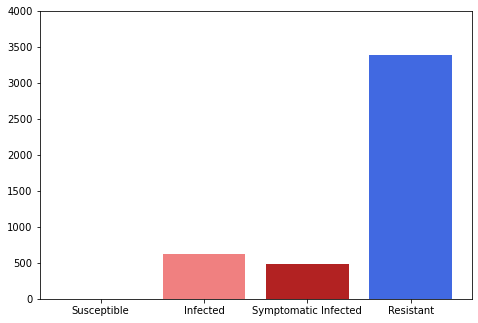

In [6]:
n_frame = simulate_epidemic(0, -1)
n_out = bar_graph(n_frame)

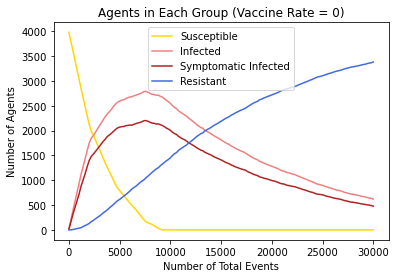

In [7]:
line_graph(n_frame, n_out, 'Agents in Each Group (Vaccine Rate = 0)')

In [8]:
# Analysis for model: vaccination rate = 200; random vaccination selection
total_vac = []
avg_inf = []
max_inf = []

for i in range (20):
    n_frame = simulate_epidemic(200, -1)
    total_vac.append(len(V))
    avg_inf.append(average_inf(n_frame))
    max_inf.append(max_inf_agents(n_frame))

total_vac_mean = np.mean(total_vac)
avg_inf_mean = np.mean(avg_inf)
max_inf_mean = np.mean(max_inf)

total_vac_ci = sc.t.interval(0.95, len(total_vac)-1, loc=total_vac_mean, scale=sc.sem(total_vac))
avg_inf_ci = sc.t.interval(0.95, len(avg_inf)-1, loc=avg_inf_mean, scale=sc.sem(avg_inf))
max_inf_ci = sc.t.interval(0.95, len(max_inf)-1, loc=max_inf_mean, scale=sc.sem(max_inf))

In [9]:
print("Total Vaccinations:", total_vac_mean, "95% CI:", total_vac_ci)
print("Average Infected Agents:", avg_inf_mean, "95% CI:", avg_inf_ci)
print("Max Infected Agents:", max_inf_mean, "95% CI:", max_inf_ci)

Total Vaccinations: 1055.0 95% CI: (990.6049269551484, 1119.3950730448516)
Average Infected Agents: 1204.1675250794326 95% CI: (1178.7449755337707, 1229.5900746250945)
Max Infected Agents: 2376.3 95% CI: (2299.978207556301, 2452.621792443699)


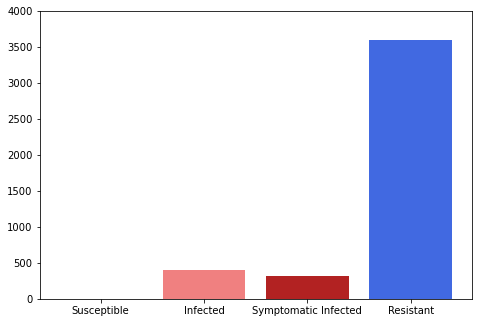

In [10]:
n_frame = simulate_epidemic(200, -1)
n_out = bar_graph(n_frame)

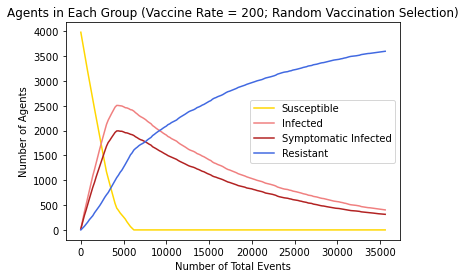

In [11]:
line_graph(n_frame, n_out, 'Agents in Each Group (Vaccine Rate = 200; Random Vaccination Selection)')

In [37]:
# Analysis for model: vaccination rate = 200; vaccinate medical workers first
total_vac = []
avg_inf = []
max_inf = []

for i in range (20):
    n_frame = simulate_epidemic(200, 0)
    total_vac.append(len(V))
    avg_inf.append(average_inf(n_frame))
    max_inf.append(max_inf_agents(n_frame))

total_vac_mean = np.mean(total_vac)
avg_inf_mean = np.mean(avg_inf)
max_inf_mean = np.mean(max_inf)

total_vac_ci = sc.t.interval(0.95, len(total_vac)-1, loc=total_vac_mean, scale=sc.sem(total_vac))
avg_inf_ci = sc.t.interval(0.95, len(avg_inf)-1, loc=avg_inf_mean, scale=sc.sem(avg_inf))
max_inf_ci = sc.t.interval(0.95, len(max_inf)-1, loc=max_inf_mean, scale=sc.sem(max_inf))

In [38]:
print("Total Vaccinations:", total_vac_mean, "95% CI:", total_vac_ci)
print("Average Infected Agents:", avg_inf_mean, "95% CI:", avg_inf_ci)
print("Max Infected Agents:", max_inf_mean, "95% CI:", max_inf_ci)

Total Vaccinations: 1046.15 95% CI: (977.9896192613988, 1114.3103807386015)
Average Infected Agents: 1217.397832214557 95% CI: (1188.8571226337378, 1245.938541795376)
Max Infected Agents: 2423.55 95% CI: (2344.287838795541, 2502.8121612044592)


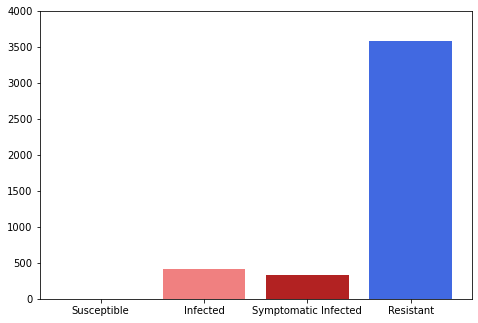

In [39]:
n_frame = simulate_epidemic(200, 0)
n_out = bar_graph(n_frame)

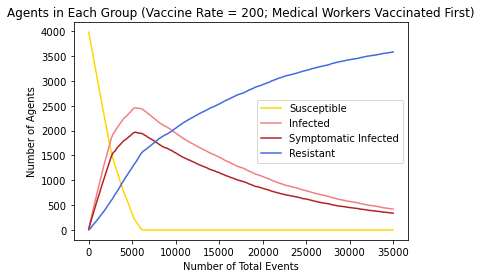

In [40]:
line_graph(n_frame, n_out, 'Agents in Each Group (Vaccine Rate = 200; Medical Workers Vaccinated First)')

In [16]:
# Analysis for model: vaccination rate = 200; vaccinate essential non-med workers first
total_vac = []
avg_inf = []
max_inf = []

for i in range (20):
    n_frame = simulate_epidemic(200, 1)
    total_vac.append(len(V))
    avg_inf.append(average_inf(n_frame))
    max_inf.append(max_inf_agents(n_frame))

total_vac_mean = np.mean(total_vac)
avg_inf_mean = np.mean(avg_inf)
max_inf_mean = np.mean(max_inf)

total_vac_ci = sc.t.interval(0.95, len(total_vac)-1, loc=total_vac_mean, scale=sc.sem(total_vac))
avg_inf_ci = sc.t.interval(0.95, len(avg_inf)-1, loc=avg_inf_mean, scale=sc.sem(avg_inf))
max_inf_ci = sc.t.interval(0.95, len(max_inf)-1, loc=max_inf_mean, scale=sc.sem(max_inf))

In [17]:
print("Total Vaccinations:", total_vac_mean, "95% CI:", total_vac_ci)
print("Average Infected Agents:", avg_inf_mean, "95% CI:", avg_inf_ci)
print("Max Infected Agents:", max_inf_mean, "95% CI:", max_inf_ci)

Total Vaccinations: 1124.15 95% CI: (1008.9205415605777, 1239.3794584394225)
Average Infected Agents: 1181.3836295993628 95% CI: (1129.5930214868606, 1233.174237711865)
Max Infected Agents: 2331.9 95% CI: (2196.909649676956, 2466.890350323044)


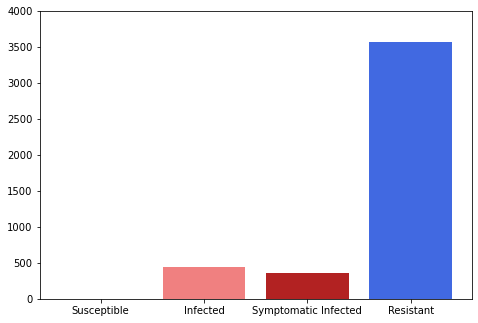

In [18]:
n_frame = simulate_epidemic(200, 1)
n_out = bar_graph(n_frame)

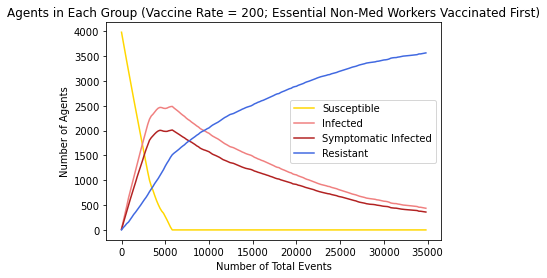

In [19]:
line_graph(n_frame, n_out, 'Agents in Each Group (Vaccine Rate = 200; Essential Non-Med Workers Vaccinated First)')

In [20]:
# Analysis for model: vaccination rate = 200; vaccinate non-essential high risk workers first
total_vac = []
avg_inf = []
max_inf = []

for i in range (20):
    n_frame = simulate_epidemic(200, 2)
    total_vac.append(len(V))
    avg_inf.append(average_inf(n_frame))
    max_inf.append(max_inf_agents(n_frame))

total_vac_mean = np.mean(total_vac)
avg_inf_mean = np.mean(avg_inf)
max_inf_mean = np.mean(max_inf)

total_vac_ci = sc.t.interval(0.95, len(total_vac)-1, loc=total_vac_mean, scale=sc.sem(total_vac))
avg_inf_ci = sc.t.interval(0.95, len(avg_inf)-1, loc=avg_inf_mean, scale=sc.sem(avg_inf))
max_inf_ci = sc.t.interval(0.95, len(max_inf)-1, loc=max_inf_mean, scale=sc.sem(max_inf))

In [21]:
print("Total Vaccinations:", total_vac_mean, "95% CI:", total_vac_ci)
print("Average Infected Agents:", avg_inf_mean, "95% CI:", avg_inf_ci)
print("Max Infected Agents:", max_inf_mean, "95% CI:", max_inf_ci)

Total Vaccinations: 1149.9 95% CI: (1084.7557887393834, 1215.0442112606167)
Average Infected Agents: 1169.2569505189574 95% CI: (1137.5523612940838, 1200.961539743831)
Max Infected Agents: 2280.95 95% CI: (2209.4933600201166, 2352.406639979883)


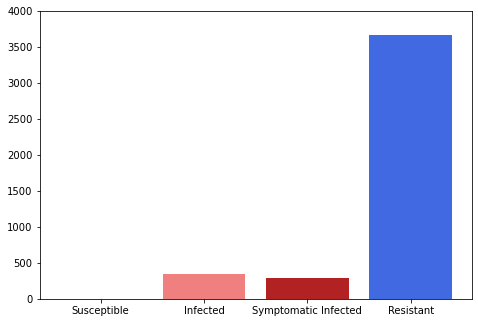

In [22]:
n_frame = simulate_epidemic(200, 2)
n_out = bar_graph(n_frame)

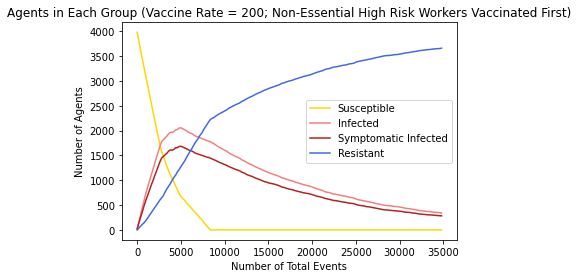

In [23]:
line_graph(n_frame, n_out,'Agents in Each Group (Vaccine Rate = 200; Non-Essential High Risk Workers Vaccinated First)')

In [24]:
# Analysis for model: vaccination rate = 200; vaccinate non-essential low risk workers first
total_vac = []
avg_inf = []
max_inf = []

for i in range (20):
    n_frame = simulate_epidemic(200, 3)
    total_vac.append(len(V))
    avg_inf.append(average_inf(n_frame))
    max_inf.append(max_inf_agents(n_frame))

total_vac_mean = np.mean(total_vac)
avg_inf_mean = np.mean(avg_inf)
max_inf_mean = np.mean(max_inf)

total_vac_ci = sc.t.interval(0.95, len(total_vac)-1, loc=total_vac_mean, scale=sc.sem(total_vac))
avg_inf_ci = sc.t.interval(0.95, len(avg_inf)-1, loc=avg_inf_mean, scale=sc.sem(avg_inf))
max_inf_ci = sc.t.interval(0.95, len(max_inf)-1, loc=max_inf_mean, scale=sc.sem(max_inf))

In [25]:
print("Total Vaccinations:", total_vac_mean, "95% CI:", total_vac_ci)
print("Average Infected Agents:", avg_inf_mean, "95% CI:", avg_inf_ci)
print("Max Infected Agents:", max_inf_mean, "95% CI:", max_inf_ci)

Total Vaccinations: 1090.3 95% CI: (1033.873665881573, 1146.7263341184268)
Average Infected Agents: 1191.261854433866 95% CI: (1167.4481814656556, 1215.0755274020762)
Max Infected Agents: 2323.55 95% CI: (2249.299178861958, 2397.8008211380425)


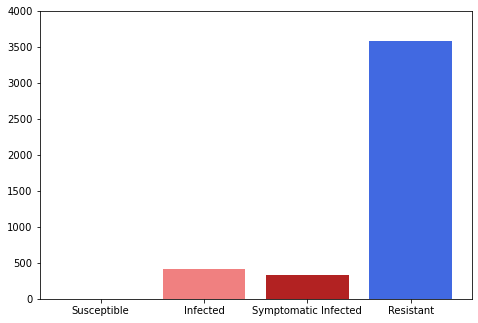

In [26]:
n_frame = simulate_epidemic(200, 3)
n_out = bar_graph(n_frame)

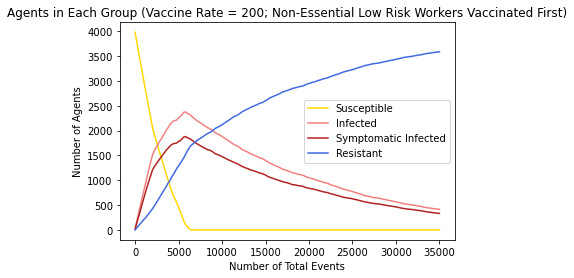

In [27]:
line_graph(n_frame, n_out, 'Agents in Each Group (Vaccine Rate = 200; Non-Essential Low Risk Workers Vaccinated First)')